# 4. Unsupervised Learning Analysis

### Name: Bingfeng Hu
### CID: 01137798

I declare that the below is of my own work, and I have worked on this assignment independently. Please see the cell below for package dependencies, uncomment to install the package dependencies.

In this notebook we look at the the information content of our news articles using unsupervised methods to see if there is indeed sufficient information content and variety. In particular, we perform LSA and LDA.

## Saving the datasets for analysis

First we take the datasets which we've saved as the test set in the `test` folder and the labelled data in the `labelled_data` folder and format them approachly into train, validation and test set data in the `combined_data_output` folder as separate json files

## 1. Review the labelling results

First we review the quality of the labels from GPT-4 compare to human labels for sentiment.

In [1]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt

# basic sklearn preprocessing dependencies
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import re

In [2]:
# SET THE SEED for replication.
SEED = 30224
np.random.seed(SEED)

In [3]:
review_df = pd.read_csv("test/manual_review_articles_bert_compliant_labelled_add_human_labels_ADDED.csv")

review_df.shape

(200, 47)

In [4]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 47 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   organizations                      200 non-null    object 
 1   uuid                               200 non-null    object 
 2   author                             116 non-null    object 
 3   url                                200 non-null    object 
 4   ord_in_thread                      200 non-null    int64  
 5   title                              200 non-null    object 
 6   locations                          200 non-null    object 
 7   highlightText                      0 non-null      float64
 8   language                           200 non-null    object 
 9   persons                            200 non-null    object 
 10  text                               200 non-null    object 
 11  external_links                     200 non-null    object 

In [5]:
accuracy_score(review_df["human_prediction"],review_df["prediction"])

0.88

In [6]:
# achieving roughly 88% accuracy which is good enough that it can generalise well to unseen text.

In [7]:
review_df["human_prediction"].value_counts()

human_prediction
 0    89
 1    66
-1    45
Name: count, dtype: int64

Text(0.5, 1.0, 'Sentiment Label Composition\nfor Testing by Human')

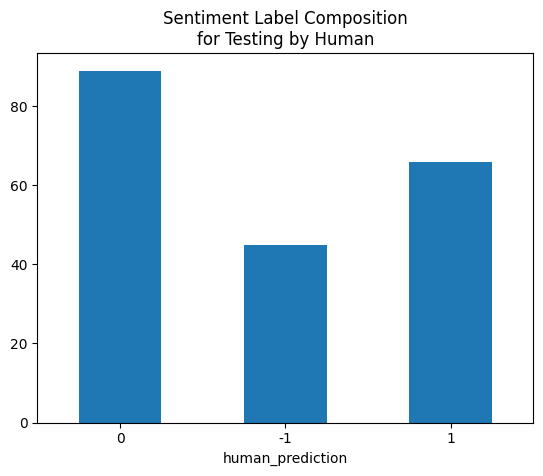

In [8]:
custom_order = [0, -1, 1]

review_df["human_prediction"].value_counts().reindex(custom_order).plot.bar(rot=0)
plt.title("Sentiment Label Composition\nfor Testing by Human")

In [9]:
review_df_pos_neg = review_df[review_df["human_prediction"].isin([1,-1])]

In [10]:
accuracy_score(review_df_pos_neg["human_prediction"],review_df_pos_neg["prediction"])

0.8648648648648649

In [11]:
# save the result here as a test set

# we will use the human labels with positive and negative labels to see how our fine-tuned models generalises

review_df_pos_neg.to_json("combined_data_output/news_analysis_test_set.json", orient="records")

We therefore see that 86.5% accuracy for positive and negative labels, and 88% for positive, neutral and negative labels, means that we are getting relatively good quality labels from GPT-4 (latest version). Therefore, given sufficient large data and diversity, this can mean that we can obtain good results from our news articles

# 2. Investigating data quality of news articles

Here, we look at the the information content of our news articles using unsupervised methods to see if there is indeed sufficient information content and variety. In particular, we perform LSA and LDA.

## 2.1 Train Test Split

First we split our labelled data for training and validation into separate training and validation datasets using a 80:20 split and saving the results in the `combined_data_output` folder

In [12]:
folder_path = "labelled_data"


# List to hold all dataframes
dataframes = []

# Iterate over each file in the directory
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        file_path = os.path.join(folder_path, filename)
        
        # Open and load the JSON file
        with open(file_path, 'r') as file:
            json_data = json.load(file)
            
            # Flatten the JSON data and convert to DataFrame
            # Adjust the record_path and meta parameters as per your JSON structure
            df = pd.json_normalize(json_data, sep='_')
            dataframes.append(df)

# Concatenate all dataframes into a single one
labelled_news_df = pd.concat(dataframes, ignore_index=True)

In [13]:
# import the news articles we have 

# then combine everything together.

labelled_news_df.shape

(5475, 46)

In [14]:
labelled_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5475 entries, 0 to 5474
Data columns (total 46 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   organizations                      5475 non-null   object
 1   uuid                               5475 non-null   object
 2   author                             5475 non-null   object
 3   url                                5475 non-null   object
 4   ord_in_thread                      5475 non-null   int64 
 5   title                              5475 non-null   object
 6   locations                          5475 non-null   object
 7   highlightText                      5475 non-null   object
 8   language                           5475 non-null   object
 9   persons                            5475 non-null   object
 10  text                               5475 non-null   object
 11  external_links                     5475 non-null   object
 12  publis

In [15]:
labelled_news_df["prediction"].value_counts()

prediction
0     2210
-1    1950
1     1315
Name: count, dtype: int64

Text(0.5, 1.0, 'Sentiment Label Composition\nfor Training and Validation by GPT-4')

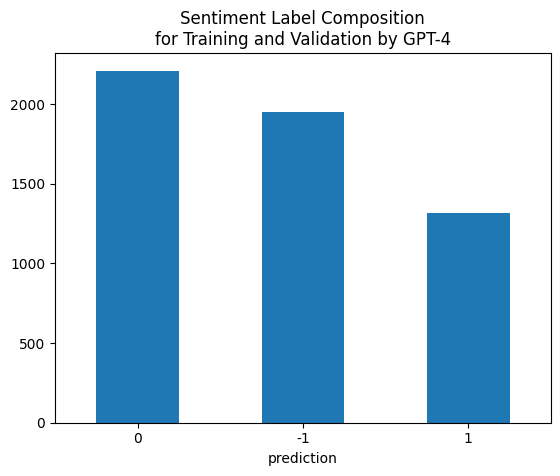

In [16]:
labelled_news_df["prediction"].value_counts().plot.bar(rot=0)
plt.title("Sentiment Label Composition\nfor Training and Validation by GPT-4")

In [17]:
# convert the label into integer

labelled_news_df["prediction"] = labelled_news_df["prediction"].astype(int)

In [18]:
# get the news such that it is just positive and negative labels

news_analysis_df = labelled_news_df[labelled_news_df["prediction"].isin([1,-1])]
news_analysis_df.shape

(3265, 46)

### Text Preprocessing

Next we perform some text preprocessing to remove noise before applying LSA and LDA

Remove the irrelevant text which were discovered from the manual review of the text

In [19]:
# remove unnnecessary text


ph_text1 = "Tip : Use comma (,) to separate multiple quotes. Learn more..."

ph_text2 = "Quotes are real-time for NASDAQ, NYSE, and NYSEAmex when available. See also delay times for other exchanges . Quotes and other information supplied by independent providers identified on the Yahoo! Finance partner page . Quotes are updated automatically, but will be turned off after 25 minutes of inactivity. Quotes are delayed at least 15 minutes. All information provided \"as is\" for informational purposes only, not intended for trading purposes or advice. Neither Yahoo! nor any of independent providers is liable for any informational errors, incompleteness, or delays, or for any actions taken in reliance on information contained herein. By accessing the Yahoo! site, you agree not to redistribute the information found therein. \nFundamental company data provided by Capital IQ . Historical chart data and daily updates provided by Commodity Systems, Inc. (CSI) . International historical chart data and daily updates provided by Morningstar, Inc . Yahoo! - News Network"

ph_text3 = "Fundamental company data provided by Capital IQ . Historical chart data and daily updates provided by Commodity Systems, Inc. (CSI) . International historical chart data and daily updates provided by Morningstar, Inc . Yahoo! - News Network"

# get the raw text preprocessed
news_analysis_df["text_full_raw_preprocessed"] = news_analysis_df["text_full"].replace(ph_text1, "").replace(ph_text2, "").replace(ph_text3,"")


# remove also the escaped versions due to the presence of special characters
ph_text1_escaped = re.escape(ph_text1)
ph_text2_escaped = re.escape(ph_text2)
ph_text3_escaped = re.escape(ph_text3)

news_analysis_df["text_full_raw_preprocessed"] = news_analysis_df["text_full_raw_preprocessed"].replace(ph_text1_escaped, "", regex=True).replace(ph_text2_escaped, "", regex=True).replace(ph_text3_escaped, "", regex=True)


/tmp/ipykernel_3277/2268640507.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_analysis_df["text_full_raw_preprocessed"] = news_analysis_df["text_full"].replace(ph_text1, "").replace(ph_text2, "").replace(ph_text3,"")
/tmp/ipykernel_3277/2268640507.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_analysis_df["text_full_raw_preprocessed"] = news_analysis_df["text_full_raw_preprocessed"].replace(ph_text1_escaped, "", regex=True).replace(ph_text2_escaped, "", regex=True).replace(ph_text3_esc

In [20]:
# belows shows that the text has been removed correctly

In [21]:
news_analysis_df[news_analysis_df["text_full"].str.contains(ph_text2_escaped)]

,organizations,uuid,author,url,ord_in_thread,title,locations,highlightText,language,persons,...,thread_replies_count,thread_uuid,entities_persons,entities_locations,entities_organizations,word_count,text_full,token_count,prediction,text_full_raw_preprocessed
17,[Centrica],6293d94bd5deec1cee4df0abb6c1e3a33a260009,,https://uk.finance.yahoo.com/news/centrica-top...,0,Centrica tops FTSE fallers on unplanned North ...,[North Morecambe],,english,[],...,0,6293d94bd5deec1cee4df0abb6c1e3a33a260009,[],[],[],337,Centrica tops FTSE fallers on unplanned North ...,486,-1,Centrica tops FTSE fallers on unplanned North ...
18,[Microsoft],936336163ca0bd88c3e0aaec542a7d7ad0ab20e9,,https://uk.finance.yahoo.com/news/microsoft-po...,0,Microsoft Posts $3.2bn Loss In Second Quarter,[],,english,[],...,0,936336163ca0bd88c3e0aaec542a7d7ad0ab20e9,[],[],[],270,Microsoft Posts $3.2bn Loss In Second Quarter\...,372,-1,Microsoft Posts $3.2bn Loss In Second Quarter\...
33,[],1a6a78325b96aff5253a68dc69bc45b0d748801b,,https://uk.finance.yahoo.com/news/britains-rou...,0,Britain's Rough gas storage site in unplanned ...,[Britain],,english,[],...,0,1a6a78325b96aff5253a68dc69bc45b0d748801b,[],[],[],158,Britain's Rough gas storage site in unplanned ...,215,-1,Britain's Rough gas storage site in unplanned ...
53,[],5d5a0fc98229b66178c53701bbb4e72a242463e3,,https://uk.finance.yahoo.com/news/low-oil-pric...,0,Low oil price domino effect to shut more North...,[North Sea],,english,[],...,0,5d5a0fc98229b66178c53701bbb4e72a242463e3,[],[],[],250,Low oil price domino effect to shut more North...,323,-1,Low oil price domino effect to shut more North...
74,[],3697c982bd3a0a1a2e052f147dad3e904c700cf0,,https://uk.finance.yahoo.com/news/sensex-gains...,0,"Sensex rises 1 pct, posts biggest single-day g...",[],,english,[],...,0,3697c982bd3a0a1a2e052f147dad3e904c700cf0,[],[],[],161,"Sensex rises 1 pct, posts biggest single-day g...",214,1,"Sensex rises 1 pct, posts biggest single-day g..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5421,[Berkshire Hathaway],03a581c88a8825634cb62b08e9f8bd3081e4487a,,https://uk.finance.yahoo.com/news/berkshire-ha...,0,Berkshire Hathaway adds to its industrial heft,[],,english,[],...,0,03a581c88a8825634cb62b08e9f8bd3081e4487a,[],[],[],299,Berkshire Hathaway adds to its industrial heft...,399,1,Berkshire Hathaway adds to its industrial heft...
5423,[NFL],af625bf2b18217f54e90179dbf1a5c17b6202920,,https://uk.finance.yahoo.com/news/twitter-sign...,0,Twitter signs multiyear deal with NFL,[],,english,[],...,0,af625bf2b18217f54e90179dbf1a5c17b6202920,[],[],[],348,Twitter signs multiyear deal with NFL\nTip : U...,474,1,"Twitter signs multiyear deal with NFL\n \nMon,..."
5440,[],5a14e1f7392211c13059bbfa2e47cfdee7795229,,https://uk.finance.yahoo.com/news/bp-h1-oil-ou...,0,BP H1 oil output at Azeri projects declines to...,[],,english,[],...,0,5a14e1f7392211c13059bbfa2e47cfdee7795229,[],[],[],345,BP H1 oil output at Azeri projects declines to...,493,-1,BP H1 oil output at Azeri projects declines to...
5456,[Citigroup],108452d5e730d8ace613926715089fb375ca2b57,,https://uk.finance.yahoo.com/news/buzz-ashmore...,0,BUZZ-Ashmore: Bounces off 7-mth lows as Citigr...,[],,english,[],...,0,108452d5e730d8ace613926715089fb375ca2b57,[],[],[],160,BUZZ-Ashmore: Bounces off 7-mth lows as Citigr...,221,1,BUZZ-Ashmore: Bounces off 7-mth lows as Citigr...


In [22]:
news_analysis_df[news_analysis_df["text_full_raw_preprocessed"].str.contains(ph_text2_escaped)]

,organizations,uuid,author,url,ord_in_thread,title,locations,highlightText,language,persons,...,thread_replies_count,thread_uuid,entities_persons,entities_locations,entities_organizations,word_count,text_full,token_count,prediction,text_full_raw_preprocessed


In [23]:
# split the data into test validation split using seed

# saving into the result in the combined_data_output folder, fine tune and change this later if needed

train_set_df , validation_set_df = train_test_split(news_analysis_df,  test_size = 0.2, random_state=SEED)

In [24]:
train_set_df.shape , validation_set_df.shape

((2612, 47), (653, 47))

In [25]:
# save the results manually to combined_data_output for the analysis output

train_set_df.to_json("combined_data_output/news_analysis_train_set.json", orient="records")

validation_set_df.to_json("combined_data_output/news_analysis_validation_set.json", orient="records")

In the sections below, we will perform unsupervised learning tasks, to investigate the information content of our news data, to see how likely any fine-tuning on our data will generalise.

## 2.2 Unsupervised Learning - LSA

Here we apply the LSA to the text to see if there are any particular meaningful topics from the preprocessed text.

In [26]:
train_set_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2612 entries, 1686 to 727
Data columns (total 47 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   organizations                      2612 non-null   object
 1   uuid                               2612 non-null   object
 2   author                             2612 non-null   object
 3   url                                2612 non-null   object
 4   ord_in_thread                      2612 non-null   int64 
 5   title                              2612 non-null   object
 6   locations                          2612 non-null   object
 7   highlightText                      2612 non-null   object
 8   language                           2612 non-null   object
 9   persons                            2612 non-null   object
 10  text                               2612 non-null   object
 11  external_links                     2612 non-null   object
 12  published

In [27]:
# add the code here for unsupervised learning for LSA - tomorrow, should be a simple augmented version here

In [28]:
# importing dependencies for text dependencies.
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from nltk.tokenize import sent_tokenize, word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [30]:
# download nltk package
nltk.download('stopwords')
nltk.download('punkt')

stopword=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bingfeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/bingfeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [31]:
# used a generic data cleaner regex patterns I've found from StackOverflow from the previous coursework

def data_cleaner(text, return_tokens = False):
    '''
    Cleans the data from special characters, urls, punctuation marks, extra spaces.
    Removes stopwords (Like if, it, the etc) and transforms the word in its native
    form using Porter Stemmer.
    '''
    text = str(text).lower() # lowercase the string
    text = re.sub('\[.*?\]', ' ', text) # replace punctuation with whitespaces.
    text = re.sub('https?://\S+|www\.\S+', ' ', text) # replacing urls with whitespaces.
    text = re.sub('<.*?>+', ' ', text) # removes special characters
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # removes punctuation
    text = re.sub('\r', ' ', text) # removes new line characters
    text = re.sub('\n', ' ', text) # removes new line characters
    text = re.sub('\w*\d\w*', ' ', text)
    #text = re.sub('–', ' ', text) # remove any additional characters we cannot remove 
    text = re.sub('[–£…»]', ' ', text) # remove any additional characters we cannot remove 
    text = text.split()

    # removing stopwords.
    text = [word for word in text if not word in stopword]

    # stemming.
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text]

    if return_tokens:

        # return relevant tokens here where needed
        return text

    #List to string.
    text = ' '.join(text)

    return text

In [32]:
# perform the LSA works
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer


In [33]:
# remove the stop words here for preprocess and then apply the workflow below

In [34]:
# review the text that has been preprocessed from the raw text
text_lsa = train_set_df["text_full_raw_preprocessed"].apply(data_cleaner, return_tokens=False)
text_lsa.values[:5]

array(['aldermor profit doubl float thu aug bst uk market close aldermor profit doubl float tim wallac telegraph hour ago challeng bank increas mortgag sme lend keep cost challeng hamburg hm news bank aldermor doubl profit first half year attract mortgag small busi custom door first set interim financi result sinc float stock market march bank report underli pre tax profit doubl net interest incom shot new loan level increas period lend small busi climb residenti mortgag lend increas six month june time margin improv aldermor kept cost net interest margin expand “we’v abl hold margin we’v abl drive cost fund ” said chief execut phillip monk ad aldermor challeng big bank deposit well lend “we’v focus deposit sme badli serv liabil side asset side balanc sheet they’v come us partli innov allow open fund account within minut ” bank’ oper incom grew cost rose push cost incom ratio mr monk said bank target ratio less end would make far effici biggest bank sector aldermore’ stock market flota

In [35]:
documents = text_lsa.to_list() # change this to additional edits and additional preprocessing where needed
len(documents)

2612

In [36]:
# preprocessing
vectoriser = TfidfVectorizer(max_features=1000) #' get the top 1000 words'
X = vectoriser.fit_transform(documents)

In [37]:
# see the TF-IDF matrix
X.shape

(2612, 1000)

### 2.2a Choosing the optimal number of topics

First we check the optimal number of topics to choose from by looking at the total variance explained

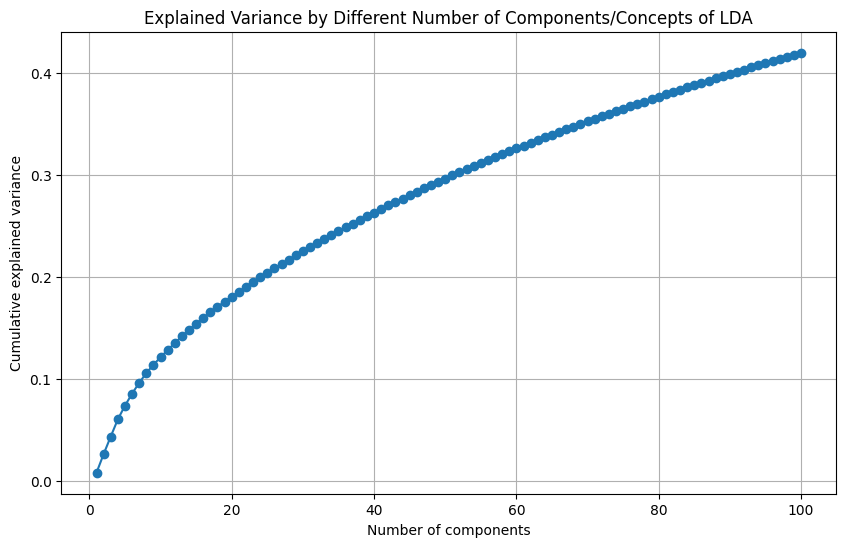

In [38]:
# stackoverflow link:  https://stackoverflow.com/questions/69091520/determine-the-correct-number-of-topics-using-latent-semantic-analysis
# Function to plot explained variance

# Plot the explained variance

# try out 100 topics for LDA with SVD, to see which one is optimal by explained variance
max_lda_concepts=100


explained_variances = []
total_var = 0

for n_components in range(1, max_lda_concepts + 1):
    svd = TruncatedSVD(n_components=n_components)
    svd.fit(X)
    total_var += svd.explained_variance_ratio_[-1]
    explained_variances.append(total_var)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_lda_concepts + 1), explained_variances, marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained Variance by Different Number of Components/Concepts of LDA')
plt.grid(True)
plt.show()

# takes about 6 minutes to run

In [40]:
explained_variances[9] # 10 topics we have 12.1% variance, 
# but again like before, we look at the first 10 topics for explainability, as the text is inherently noisy

0.12119091519756788

In [41]:
# choose 10 for interpretability

In [42]:
# get review document topic matrix entries

concept_no = 10 # number of topics to apply LSA

# PErform LSA by applying SVD
svd = TruncatedSVD(n_components=concept_no)  # Choose the number of components as 10
document_concept_matrix = svd.fit_transform(X)
Sigma =  svd.singular_values_ # signular values matrix
term_concept_matrix = svd.components_.T # take transpose of components

### 2.2b View Singular Values of latent components/concepts of LSA

Review the importance of the singular values to review the importance of the concepts of LSA

/tmp/ipykernel_3277/3882211926.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(1, 11))


Text(0.5, 0, 'LSA Concept/Topic')

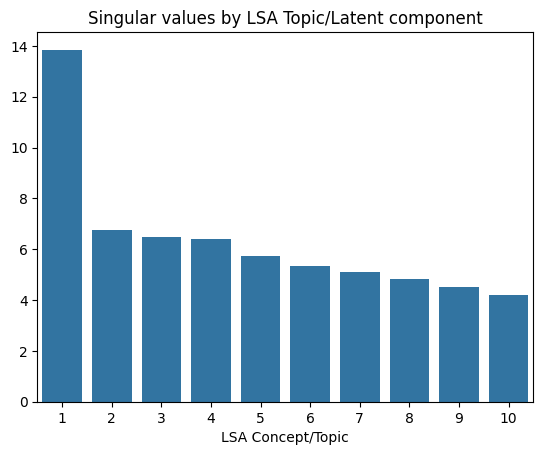

In [43]:
fig, ax = plt.subplots()
sns.barplot(x=list(range(len(Sigma))), y = Sigma)
ax.set_xticklabels(range(1, 11))
plt.title("Singular values by LSA Topic/Latent component")
plt.xlabel("LSA Concept/Topic")

### 2.2c Review the Term (word) Concept Matrix in LSA

Review the Term Concept matrix in LSA. Here we look at the most positive and negative values of the terms by concept to help us interpret the concepts.

In [44]:
terms = vectoriser.get_feature_names_out()

term_topic_df = pd.DataFrame(data =  svd.components_.T,
                                 index = terms,
                                 columns = [f'Latent_concept_{r}' for r in range(1, 11)])

term_topic_df

,Latent_concept_1,Latent_concept_2,Latent_concept_3,Latent_concept_4,Latent_concept_5,Latent_concept_6,Latent_concept_7,Latent_concept_8,Latent_concept_9,Latent_concept_10
abl,0.009228,0.006977,-0.011078,-0.006871,-0.000029,-0.002930,-0.004780,-0.006953,0.002632,-0.000625
acceler,0.010566,-0.005770,-0.003653,0.002973,-0.001124,-0.000280,-0.012952,0.012259,-0.002432,0.002675
access,0.032525,0.063299,0.037726,-0.016661,0.002736,-0.030578,0.098170,0.075654,0.015093,0.032634
accord,0.051423,-0.018220,-0.030681,-0.017099,-0.012094,-0.014031,-0.049155,-0.035174,0.043853,-0.037026
account,0.035265,0.040579,0.004573,-0.020560,-0.002412,-0.015137,0.034122,0.053583,0.028481,0.008518
...,...,...,...,...,...,...,...,...,...,...
yet,0.010236,0.009380,-0.009443,-0.000536,0.000493,-0.002549,0.003942,0.003969,-0.001718,0.005893
yield,0.025514,-0.017996,-0.036870,0.038464,-0.024892,0.038553,-0.022102,0.005639,0.063735,-0.017811
york,0.039585,-0.002117,-0.009770,-0.011944,0.023592,-0.026863,-0.031891,-0.056762,0.077726,0.030960
yuan,0.023680,-0.016900,-0.016153,0.032163,0.003513,-0.036606,-0.026237,0.010434,-0.022371,-0.121162


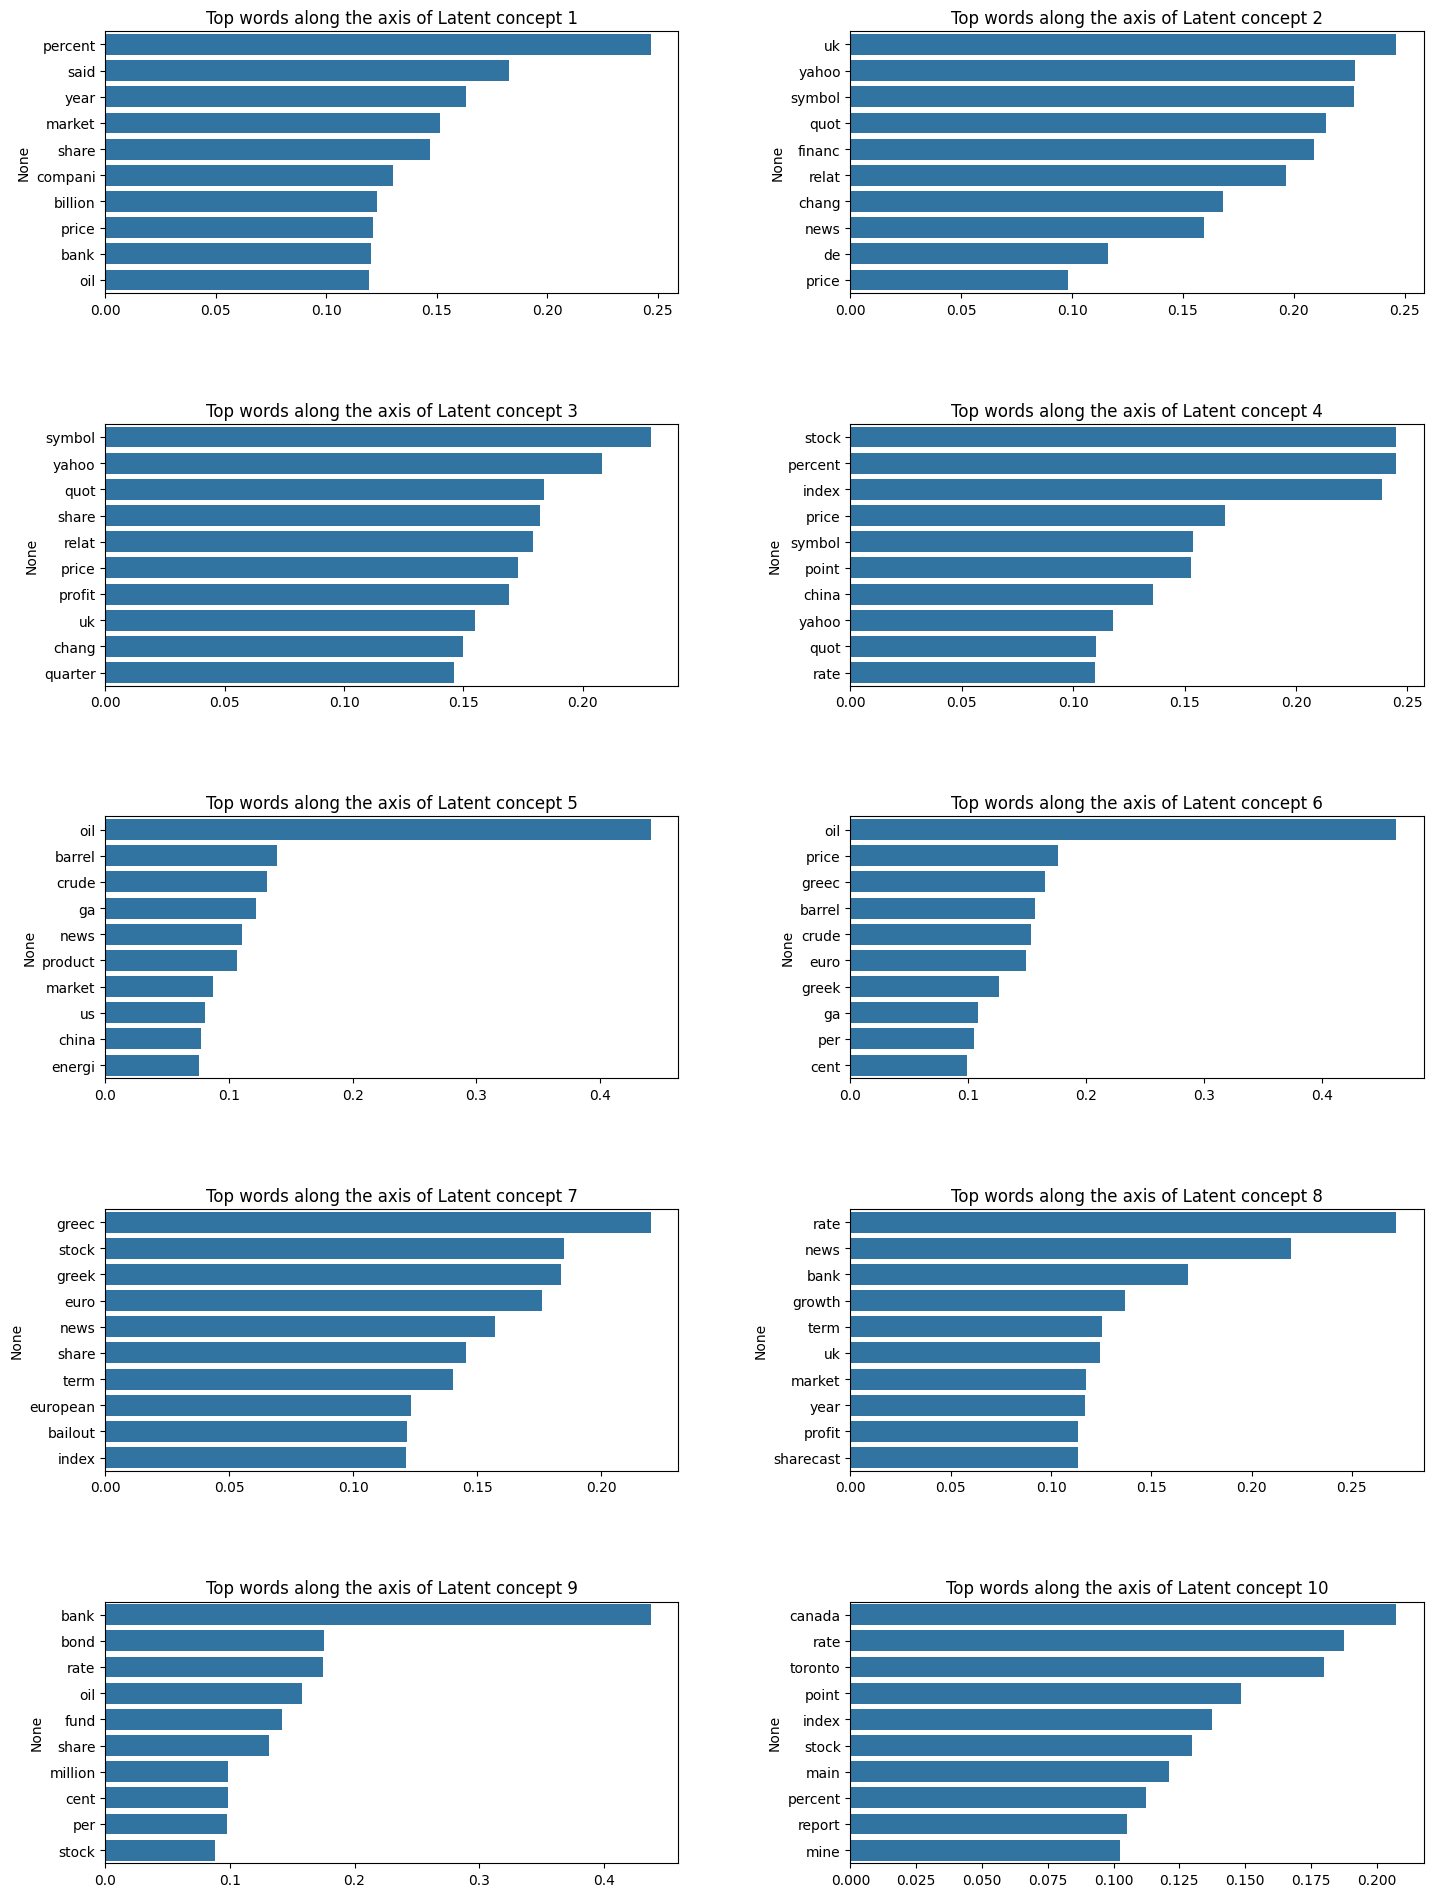

In [45]:
# create the subplot for words for each topic
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
fig.tight_layout(pad=5.0)

for i in range(1, 11):
    #  plot out an importance plot for each conept
    data = term_topic_df[f'Latent_concept_{i}']
    data = data.sort_values(ascending=False)
    top_10 = data[:10]

    row, col = (i-1) // 2, (i-1) % 2

    axes[row, col].set_title(f'Top words along the axis of Latent concept {i}')
    sns.barplot(x=top_10.values, y=top_10.index, ax=axes[row, col])

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

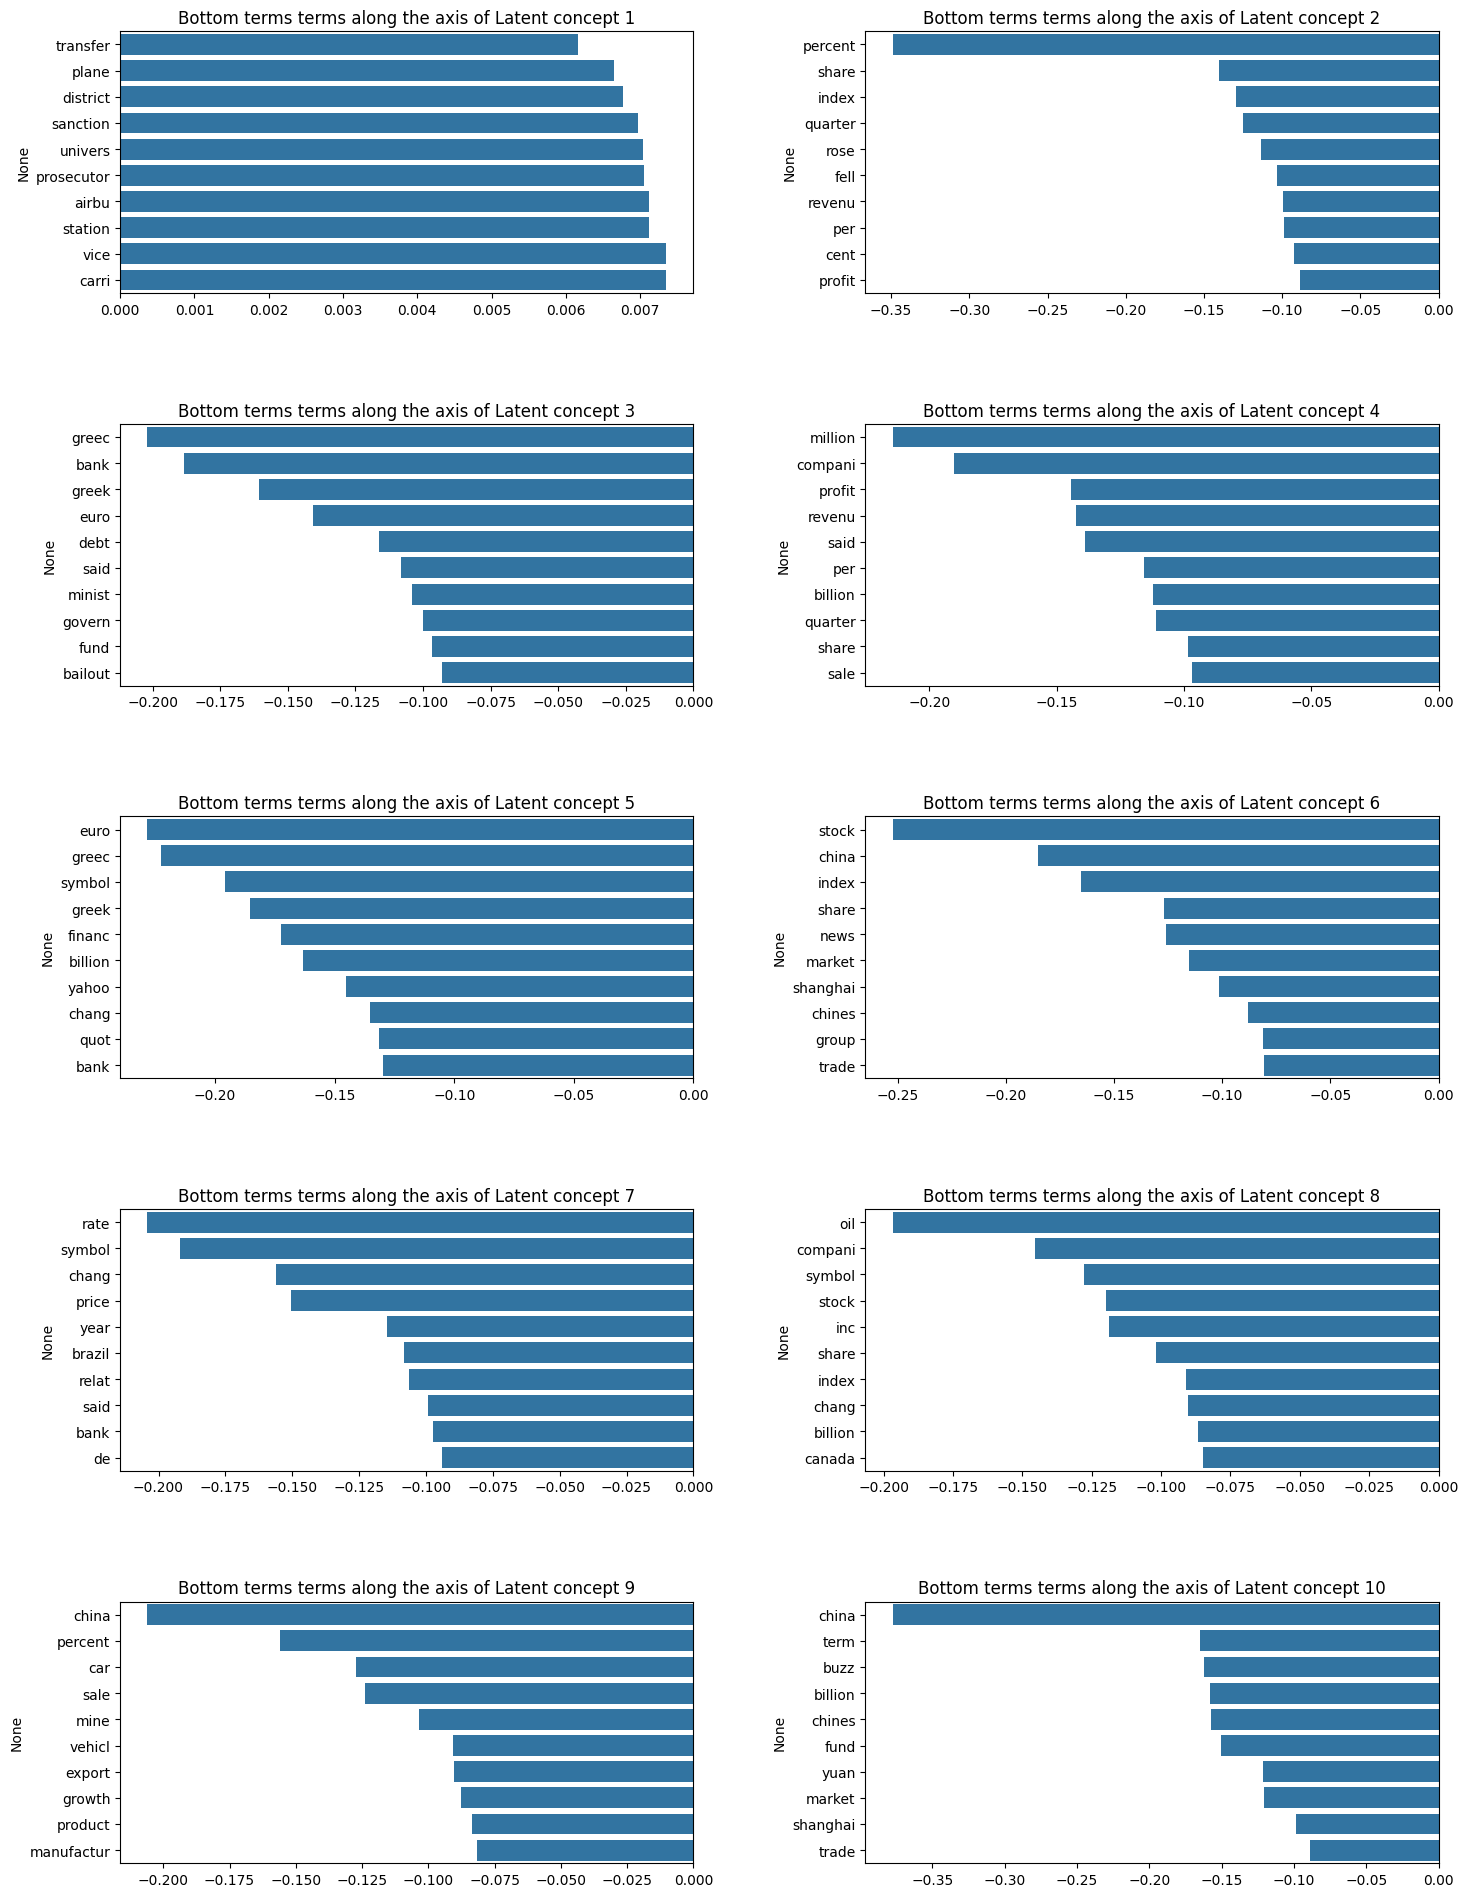

In [46]:
# create subplots for 10 topics for the lowest 10 values
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
fig.tight_layout(pad=5.0)

for i in range(1, 11):
    #  plot out an importance plot for each concept
    data = term_topic_df[f'Latent_concept_{i}']
    data = data.sort_values(ascending=True)
    top_10 = data[:10]

    row, col = (i-1) // 2, (i-1) % 2

    axes[row, col].set_title(f'Bottom terms terms along the axis of Latent concept {i}')
    sns.barplot(x=top_10.values, y=top_10.index, ax=axes[row, col])

# plot out the plots
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

In [47]:
# see again some overlapping topics for LSA

### 2.2d Review T-SNE visualisation of dominant concepts of the topic word matrix of LSA

In [48]:
# make sure t-sne has the right random seed here!!
SEED, concept_no

(30224, 10)

In [49]:
term_concept_matrix

array([[ 0.00922798,  0.00697653, -0.01107796, ..., -0.00695281,
         0.00263158, -0.00062548],
       [ 0.0105664 , -0.0057698 , -0.00365307, ...,  0.01225943,
        -0.0024318 ,  0.00267509],
       [ 0.03252471,  0.06329869,  0.03772563, ...,  0.07565402,
         0.015093  ,  0.03263372],
       ...,
       [ 0.03958505, -0.00211693, -0.0097704 , ..., -0.05676237,
         0.07772623,  0.03095961],
       [ 0.02367966, -0.01690044, -0.01615302, ...,  0.01043372,
        -0.02237111, -0.12116155],
       [ 0.01689625,  0.0137579 , -0.0512731 , ..., -0.01678543,
        -0.03211509,  0.00180123]])

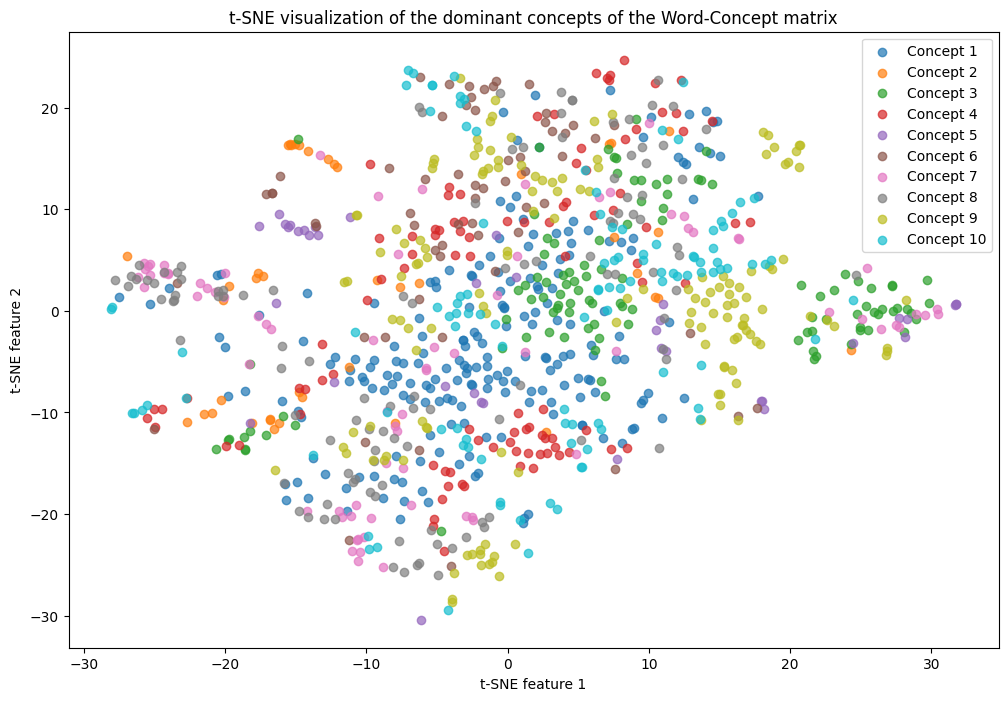

In [50]:

dominant_topic_by_word = np.argmax(np.abs(term_concept_matrix), axis=1)

tsne_model = TSNE(n_components=2, perplexity=50, random_state=SEED)
word_tsne = tsne_model.fit_transform(term_concept_matrix)

plt.figure(figsize=(12, 8))
for i in range(concept_no):
    indices = dominant_topic_by_word == i
    plt.scatter(word_tsne[indices, 0], word_tsne[indices, 1], alpha=0.7, label=f'Concept {i+1}')

# create the plot for the word concept matrix
plt.title('t-SNE visualization of the dominant concepts of the Word-Concept matrix')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()

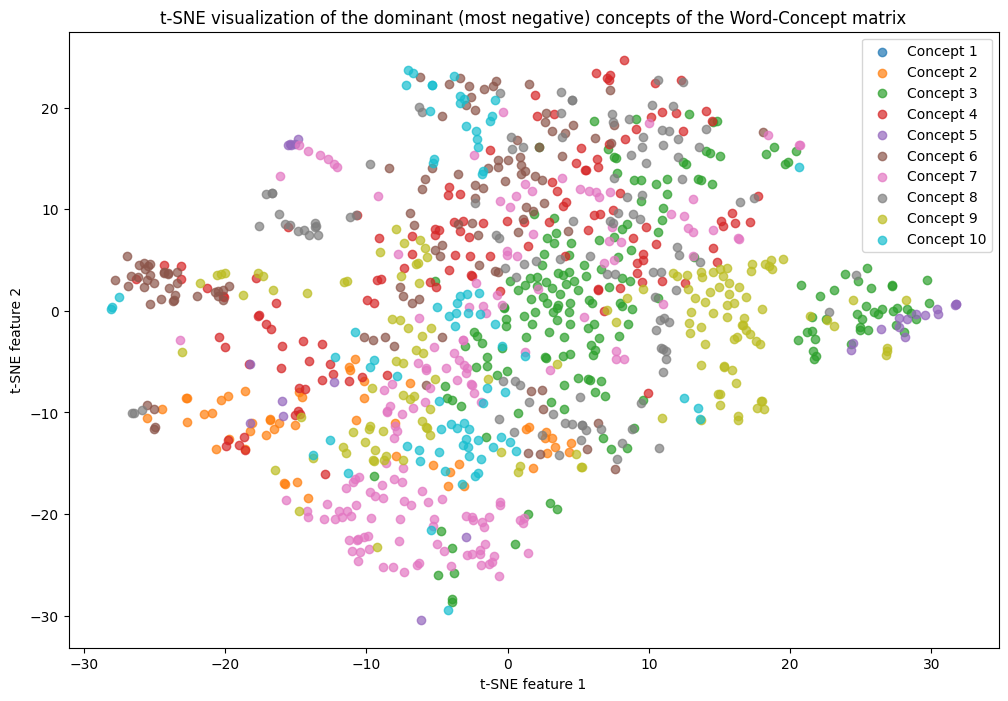

In [51]:

dominant_topic_by_word = np.argmin(term_concept_matrix, axis=1)

tsne_model = TSNE(n_components=2, perplexity=50, random_state=SEED)
word_tsne = tsne_model.fit_transform(term_concept_matrix)

plt.figure(figsize=(12, 8))
for i in range(concept_no):
    indices = dominant_topic_by_word == i
    plt.scatter(word_tsne[indices, 0], word_tsne[indices, 1], alpha=0.7, label=f'Concept {i+1}')

# create the plot for the word concept matrix
plt.title('t-SNE visualization of the dominant (most negative) concepts of the Word-Concept matrix')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()

### 2.2e Review the Document Concept Matrix in LSA using T-SNE

Review the Document Concept matrix in LSA. Here we look at the most positive and negative values of the Document by concept to help us interpret the concepts.

Replicating approach from https://philippeheitzmann.com/2022/02/topic-modeling-in-python/

In [52]:
# review the dominant terms of document concept matrix using t-sne

document_concept_matrix

array([[ 0.30943538, -0.00137286, -0.01708187, ...,  0.15632566,
         0.19054393, -0.04951665],
       [ 0.28119705,  0.14517151, -0.02020456, ...,  0.37833588,
         0.21084719,  0.10407097],
       [ 0.27418999, -0.13199249, -0.04477056, ...,  0.1754019 ,
        -0.03015759,  0.17314304],
       ...,
       [ 0.16911557,  0.01722867, -0.07940352, ..., -0.09506593,
        -0.07530718,  0.00569268],
       [ 0.32185843,  0.08722283,  0.00905245, ...,  0.21493321,
         0.04709747, -0.10232722],
       [ 0.24452253, -0.09129781, -0.01384607, ...,  0.00460705,
        -0.13467771, -0.01026257]])

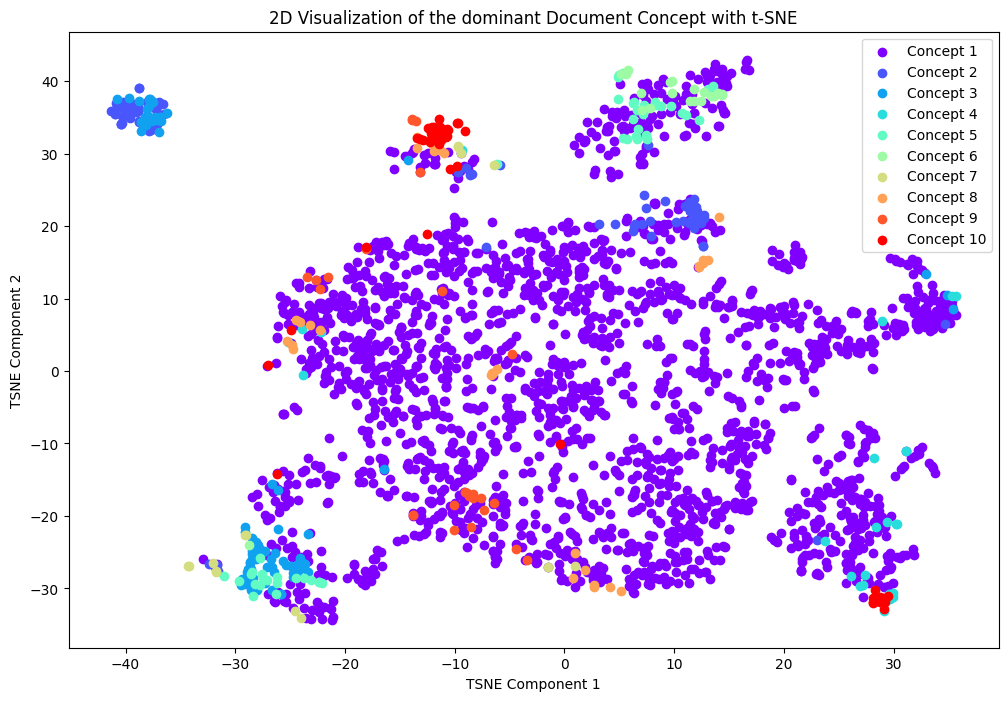

In [53]:

# take the dominant terms for the document concept matrix

# scaler = StandardScaler()
# normalised_matrix = scaler.fit_transform(document_concept_matrix)

dominant_topics = np.argmax(np.abs(document_concept_matrix), axis=1) # Find the dominant topic for each document

# dominant_topics = np.argmax(np.abs(normalised_matrix), axis=1) # Find the dominant topic for each document

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=50, random_state=SEED)
embedded = tsne.fit_transform(document_concept_matrix)

# embedded = tsne.fit_transform(normalised_matrix)

colors = plt.cm.rainbow(np.linspace(0, 1, concept_no))

plt.figure(figsize=(12, 8))

# Plot each topic
for topic_id in range(concept_no):
    indices = dominant_topics == topic_id
    plt.scatter(embedded[indices, 0], embedded[indices, 1], label=f'Concept {topic_id + 1}', c=[colors[topic_id]])

# create the plot for the word concept matrix
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('2D Visualization of the dominant Document Concept with t-SNE')
plt.legend()
plt.show()

In [153]:
concept_no

10

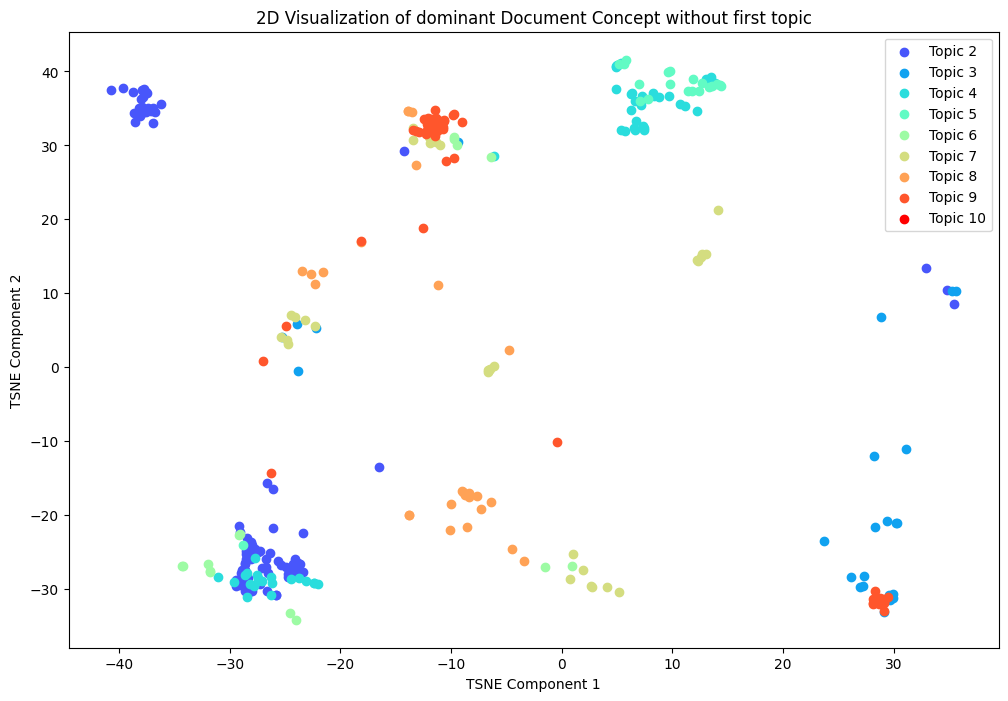

In [54]:
# Create the scatter plot with separate color for each topic
plt.figure(figsize=(12, 8))

# Plot each topic
for i, color in zip(range(1, concept_no+1), colors):

    if i == 1:
        continue
    indices = dominant_topics == i
    plt.scatter(embedded[indices, 0], embedded[indices, 1], c=[color], label=f'Topic {i}')

plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('2D Visualization of dominant Document Concept without first topic')

# Add a legend
plt.legend()
plt.show()

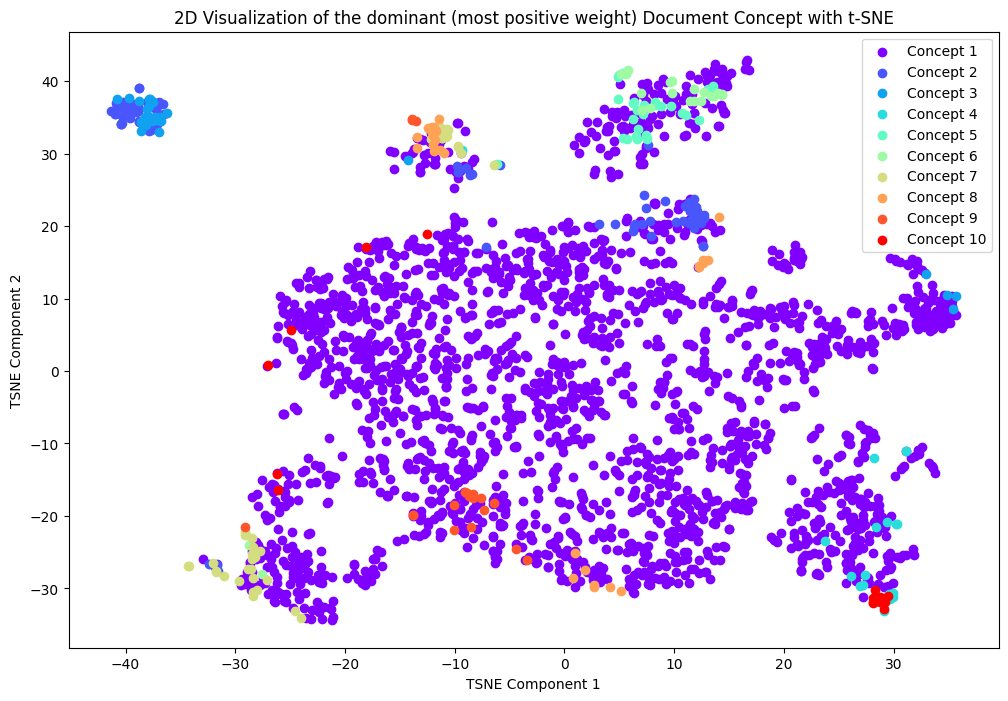

In [55]:
# take the dominant positive terms for the document concept matrix
dominant_topics = np.argmax(document_concept_matrix, axis=1) # Find the dominant topic for each document

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=50, random_state=SEED)
embedded = tsne.fit_transform(document_concept_matrix)

colors = plt.cm.rainbow(np.linspace(0, 1, concept_no))

plt.figure(figsize=(12, 8))

# Plot each topic
for topic_id in range(concept_no):
    indices = dominant_topics == topic_id
    plt.scatter(embedded[indices, 0], embedded[indices, 1], label=f'Concept {topic_id + 1}', c=[colors[topic_id]])

# create the plot for the word concept matrix
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('2D Visualization of the dominant (most positive weight) Document Concept with t-SNE')
plt.legend()
plt.show()

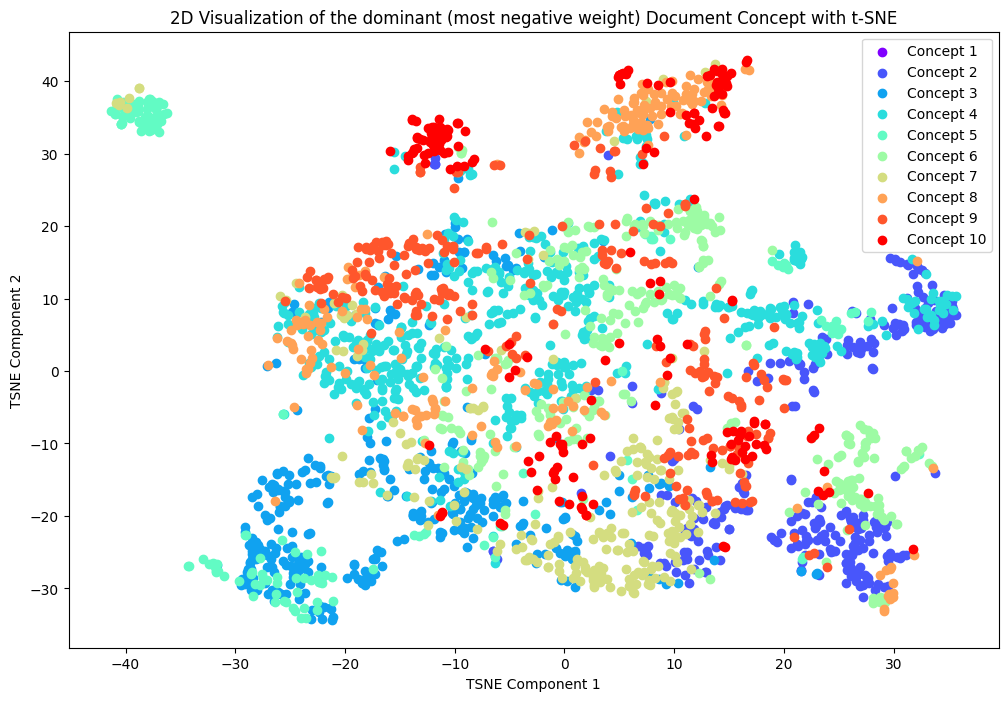

In [56]:
# take the dominant negative terms for the document concept matrix
dominant_topics = np.argmin(document_concept_matrix, axis=1) # Find the dominant topic for each document

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=50, random_state=SEED)
embedded = tsne.fit_transform(document_concept_matrix)

colors = plt.cm.rainbow(np.linspace(0, 1, concept_no))

plt.figure(figsize=(12, 8))

# Plot each topic
for topic_id in range(concept_no):
    indices = dominant_topics == topic_id
    plt.scatter(embedded[indices, 0], embedded[indices, 1], label=f'Concept {topic_id + 1}', c=[colors[topic_id]])

# create the plot for the word concept matrix
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('2D Visualization of the dominant (most negative weight) Document Concept with t-SNE')
plt.legend()
plt.show()

## 2.3 Unsupervised Learning - LDA

We next interepret the information content of our news articles using Latent Dirichlet Allocation (LDA)

In [34]:
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import common_texts
from gensim.models import LdaMulticore, CoherenceModel # coherence to find the optimal number of topics

import matplotlib.colors as mcolors
from pyrolite.comp.codata import logratiomean # pip install pyrolite
import itertools

In [36]:
text_lda = train_set_df["text_full_raw_preprocessed"]
text_lda.values[:5]

array(['Aldermore profits double after float\n \nThu, Aug 27, 2015, 18:18 BST - UK Markets closed Aldermore profits double after float By Tim Wallace | Telegraph – 3 hours ago 0.000 \nThe challenger bank increased mortgage and SME lending, while keeping costs down \nChallenger (Hamburg: 4SE.HM - news ) bank Aldermore more than doubled its profits in the first half of the year as it attracted more mortgage and small business customers through its doors. \nIn its first set of interim financial results since floating on the stock market in March, the bank reported that underlying pre-tax profits more than doubled to £44m. \nNet interest income shot up 50pc, as new loan levels increased 14pc to £1.2bn over the period. \nLending to small businesses climbed by 12pc to £2.5bn while residential mortgage lending increased by 14pc to £2.9bn in the six months to June 30. \nAt the same time margins improved as Aldermore kept its own costs down its net interest margin expanded to 3.6pc. \n“We’ve be

In [37]:
len(text_lda)

2612

In [ ]:
# preprocess our text to remove any unncessary noisy text

docs_tok = text_lda.apply(data_cleaner, return_tokens=True)

In [39]:
len(docs_tok) 

2612

In [40]:
docs_tok.values[:5] # change remove "-" character in the code above!!

array([list(['aldermor', 'profit', 'doubl', 'float', 'thu', 'aug', 'bst', 'uk', 'market', 'close', 'aldermor', 'profit', 'doubl', 'float', 'tim', 'wallac', 'telegraph', 'hour', 'ago', 'challeng', 'bank', 'increas', 'mortgag', 'sme', 'lend', 'keep', 'cost', 'challeng', 'hamburg', 'hm', 'news', 'bank', 'aldermor', 'doubl', 'profit', 'first', 'half', 'year', 'attract', 'mortgag', 'small', 'busi', 'custom', 'door', 'first', 'set', 'interim', 'financi', 'result', 'sinc', 'float', 'stock', 'market', 'march', 'bank', 'report', 'underli', 'pre', 'tax', 'profit', 'doubl', 'net', 'interest', 'incom', 'shot', 'new', 'loan', 'level', 'increas', 'period', 'lend', 'small', 'busi', 'climb', 'residenti', 'mortgag', 'lend', 'increas', 'six', 'month', 'june', 'time', 'margin', 'improv', 'aldermor', 'kept', 'cost', 'net', 'interest', 'margin', 'expand', '“we’v', 'abl', 'hold', 'margin', 'we’v', 'abl', 'drive', 'cost', 'fund', '”', 'said', 'chief', 'execut', 'phillip', 'monk', 'ad', 'aldermor', 'challeng'

In [41]:
# now build the term frequency matrix as required by LDA

common_dictionary = Dictionary(docs_tok)

common_corpus = [common_dictionary.doc2bow(text) for text in docs_tok]

In [42]:
# find the most optimal number of topics, using default number parameters for Lda Multi core.

In [43]:
# finding the optimal number of topics between 2 and 10

# TAKES 7 minutes to run BEWARE!!
min_topics = 2
max_topics = 10

model_list = []
coherence_values = []

for num_topics in range(min_topics, max_topics + 1):
    # we train the lda model - using the same code from the lda lab in uda
    lda_model = LdaMulticore(corpus=common_corpus,
                             id2word=common_dictionary,
                             num_topics=num_topics,
                             passes=10)
    
    model_list.append(lda_model)
    
    # here we calculate the coherence score
    # recommended method for optimal topic on matheworks and stackoverflow
    # https://stackoverflow.com/questions/17421887/how-to-determine-the-number-of-topics-for-lda
    # https://uk.mathworks.com/help/textanalytics/ug/choose-number-of-topics-for-LDA-model.html
    coherence_model_lda = CoherenceModel(model=lda_model, texts=docs_tok, dictionary=common_dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

# select the optimal model topics based on stackoverflow
optimal_model_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[optimal_model_index]
optimal_num_topics = min_topics + optimal_model_index

print("Optimal Number of Topics:", optimal_num_topics)

# create a graph from the above, for this.

Optimal Number of Topics: 9


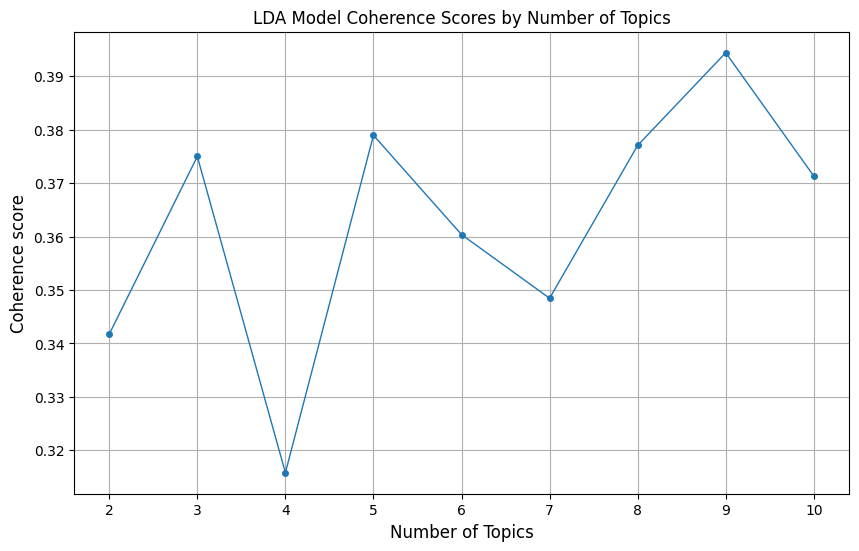

In [44]:
# create the optimal topics

topics_range = range(min_topics, max_topics + 1)

plt.figure(figsize=(10, 6))
plt.plot(topics_range, coherence_values, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("LDA Model Coherence Scores by Number of Topics")
plt.xticks(topics_range)
plt.grid(True)

# Running Latent Dirichlet analysis 

We run LDA using the most optimal number of topics by coherence score - 9 topics

In [46]:
# Run LDA

num_topics = 9
lda_model = LdaMulticore(corpus=common_corpus,
                         id2word=common_dictionary,
                         num_topics=num_topics,
                        passes=10)

## 2.3a Interpreting the word importance by topic

We interpret the estimated topic word distribution, which will allow us to have a better understanding of the topics, and what they represent.

/tmp/ipykernel_8958/3391916244.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_8958/3391916244.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_8958/3391916244.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_8958/3391916244.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'wor

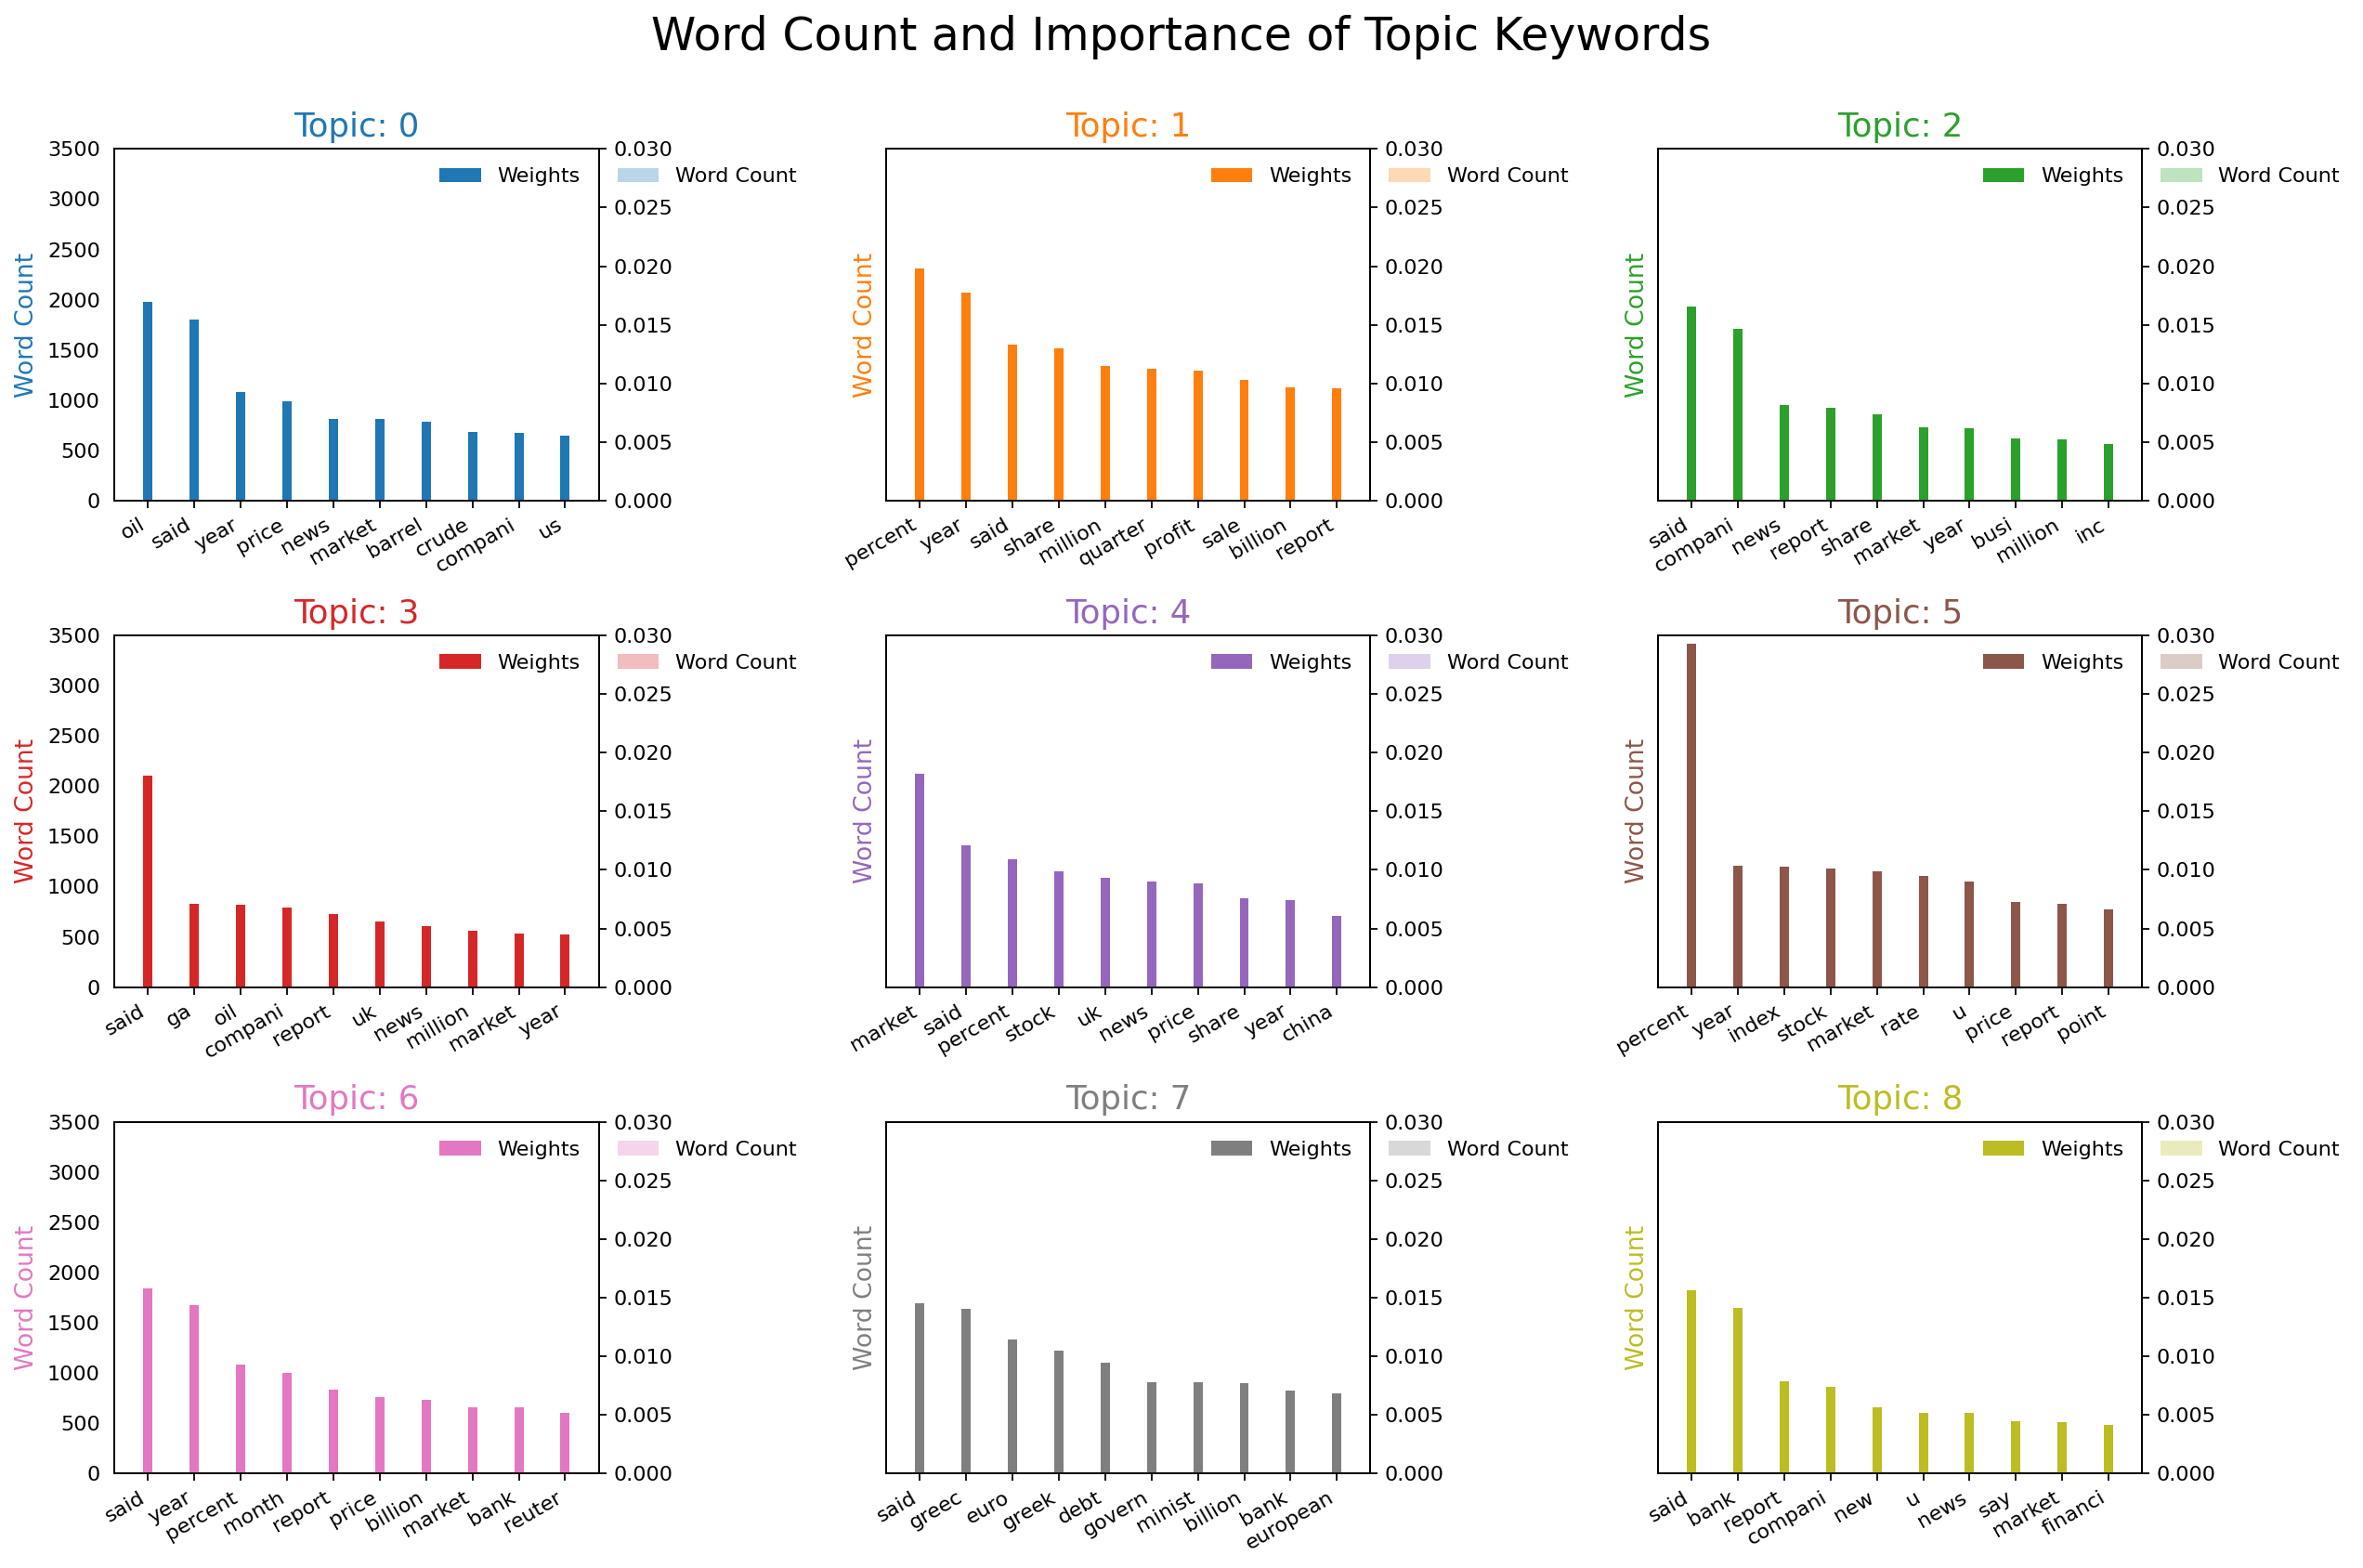

In [49]:
topics = lda_model.show_topics(formatted=False)
counter = Counter(common_dictionary)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# change the code below to be in another format here.

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# Visualising LDA using T-SNE

We then try to visualise the dominant topics of LDA in the estimated document topic distributions from LDA.

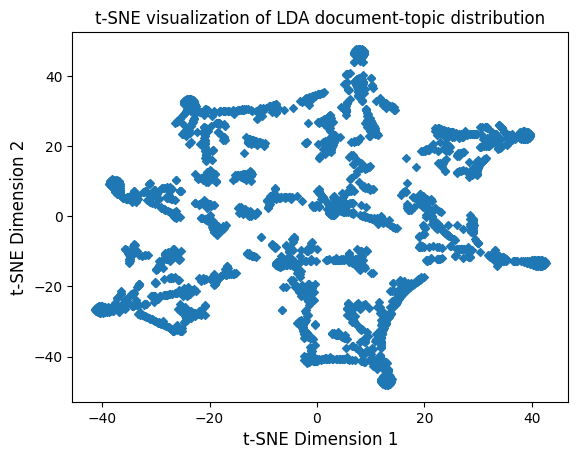

In [50]:
import gensim

# get gensim representation of document topic matrix
doc_topic_matrix = [lda_model.get_document_topics(bow) for bow in common_corpus]

# convert to document-topic matrix
matrix = gensim.matutils.corpus2dense(doc_topic_matrix, num_terms=lda_model.num_topics)

# get dominant topic for each document
dominant_topic = np.argmax(matrix, axis=0)

# t-SNE
tsne_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, random_state=0)
tsne_values = tsne_model.fit_transform(matrix.T)

x = tsne_values[:, 0]
y = tsne_values[:, 1]
plt.scatter(x, y)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE visualization of LDA document-topic distribution')

/tmp/ipykernel_8958/3590571696.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_values[indices, 0], tsne_values[indices, 1], c=color, label=f'Topic {i}')


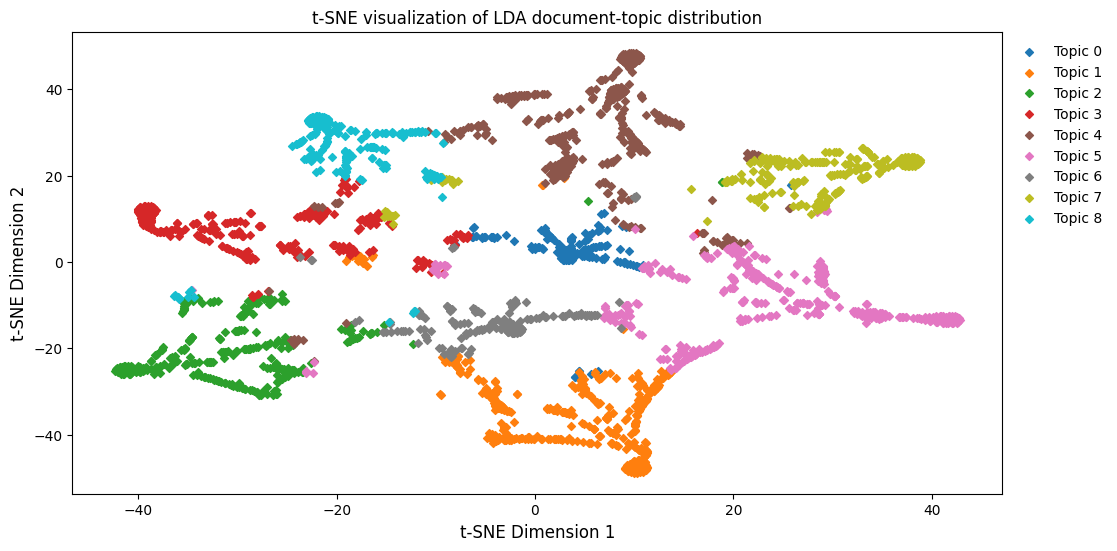

In [61]:
doc_topic_matrix = [lda_model.get_document_topics(bow) for bow in common_corpus]

# convert to document-topic matrix
matrix = gensim.matutils.corpus2dense(doc_topic_matrix, num_terms=lda_model.num_topics)

# get dominant topic for each document
dominant_topic = np.argmax(matrix, axis=0)

# t-SNE
tsne_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, random_state=0)
tsne_values = tsne_model.fit_transform(matrix.T)

colors = plt.cm.tab10(np.linspace(0, 1, 9))

plt.figure(figsize=(12, 6))
for i, color in zip(range(lda_model.num_topics), colors):
    indices = dominant_topic == i
    plt.scatter(tsne_values[indices, 0], tsne_values[indices, 1], c=color, label=f'Topic {i}')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE visualization of LDA document-topic distribution')
plt.legend(loc='best')

In [ ]:
# we see meaningful clusters from the LDA topics above

In [59]:
matrix.shape

(9, 2612)